In [134]:
import sklearn.experimental.enable_hist_gradient_boosting
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier, GradientBoostingRegressor
import pandas as pd
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import svm

from surprise import NormalPredictor, SVD, NMF, SlopeOne, CoClustering, KNNBasic, KNNWithZScore, KNNWithMeans, KNNBaseline, SVDpp
from surprise import Dataset
from surprise import Reader
#from surprise.model_selection import cross_validate, RandomizedSearchCV

In [165]:
df = pd.read_csv('dataset_clean_features.csv')

In [166]:
prop_val = 0.2
indices = np.array(list(range(len(df))))
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:int(0.5 * len(indices))],  indices[int(0.5 * len(indices)):int((0.5 + prop_val) * len(indices))], indices[int((0.5 + prop_val) * len(indices)):]

ct = ColumnTransformer(
    [("categorical", OneHotEncoder(sparse=False), ['itemID', "userID", 'MentalHealthAnxiety', "Age", 'MentalHealthDepression', 'MentalHealthADHD', 'Sex'])])

X = ct.fit_transform(df.drop(["CountryofResidence", "rating", ], axis=1))

y = df["rating"]

X_train, X_test, X_val, y_train, y_test, y_val = X[train_indices], \
                                                 X[test_indices], \
                                                 X[val_indices], \
                                                 y[train_indices], \
                                                 y[test_indices], \
                                                 y[val_indices]

df_surprise_train = df[["userID", "itemID", "rating"]].iloc[train_indices]
df_surprise_test = df[["userID", "itemID", "rating"]].iloc[test_indices]
df_surprise_val = df[["userID", "itemID", "rating"]].iloc[val_indices]
df_surprise_train_val = df[["userID", "itemID", "rating"]].iloc[list(train_indices) + list(val_indices)]

In [167]:
suprise_model_1 = KNNBaseline(k=60, min_k=2, sim_options={'name': 'pearson_baseline', 'user_based': True})
suprise_model_2 = SVD(**{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1})


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
new_trainset = Dataset.load_from_df(df_surprise_train, reader).build_full_trainset()
new_trainset_val = Dataset.load_from_df(df_surprise_train_val, reader).build_full_trainset()

In [168]:
res_df = pd.DataFrame()
n = 20


In [169]:
for _ in range(20):
    res_dic = {}
    suprise_model_1.fit(new_trainset)
    suprise_model_2.fit(new_trainset)
    prediction_surprise_1 = lambda row: suprise_model_1.predict(uid=row["userID"], iid=row["itemID"]).est
    prediction_surprise_2 = lambda row: suprise_model_2.predict(uid=row["userID"], iid=row["itemID"]).est
    val_predictions_surprise_1 = df_surprise_val.apply(prediction_surprise_1, axis=1)
    test_predictions_surprise_1 = df_surprise_test.apply(prediction_surprise_1, axis=1)
    val_predictions_surprise_2 = df_surprise_val.apply(prediction_surprise_2, axis=1)
    test_predictions_surprise_2 = df_surprise_test.apply(prediction_surprise_2, axis=1)

    X_val_both = np.concatenate((val_predictions_surprise_1.values.reshape(-1, 1), val_predictions_surprise_2.values.reshape(-1, 1)), axis=1)
    X_test_both = np.concatenate((test_predictions_surprise_1.values.reshape(-1, 1), test_predictions_surprise_2.values.reshape(-1, 1)), axis=1)
    clf_stacking = RandomForestRegressor()
    clf_stacking.fit(X_val_both, y_val)

    res_dic["stacking_rmse"] = mean_squared_error(y_test, clf_stacking.predict(X_test_both), squared=False)
    res_dic["stacking_mae"] = mean_absolute_error(y_test, clf_stacking.predict(X_test_both))

    X_val_KNN = val_predictions_surprise_1.values.reshape(-1, 1)
    X_test_KNN = test_predictions_surprise_1.values.reshape(-1, 1)
    clf_stacking_KNN = RandomForestRegressor()
    clf_stacking_KNN.fit(X_val_KNN, y_val)

    res_dic["stacking_KNN_rmse"] = mean_squared_error(y_test, clf_stacking_KNN.predict(X_test_KNN), squared=False)
    res_dic["stacking_KNN_mae"] = mean_absolute_error(y_test, clf_stacking_KNN.predict(X_test_KNN))

    X_val_SVD = val_predictions_surprise_2.values.reshape(-1, 1)
    X_test_SVD = test_predictions_surprise_2.values.reshape(-1, 1)
    clf_stacking_SVD = RandomForestRegressor()
    clf_stacking_SVD.fit(X_val_SVD, y_val)

    res_dic["stacking_SVD_rmse"] = mean_squared_error(y_test, clf_stacking_SVD.predict(X_test_SVD), squared=False)
    res_dic["stacking_SVD_mae"] = mean_absolute_error(y_test, clf_stacking_SVD.predict(X_test_SVD))


    suprise_model_1.fit(new_trainset_val)
    suprise_model_2.fit(new_trainset_val)
    test_predictions_surprise_1 = df_surprise_test.apply(prediction_surprise_1, axis=1)
    test_predictions_surprise_2 = df_surprise_test.apply(prediction_surprise_2, axis=1)
    res_dic["surprise_KNN_test_rmse"] = mean_squared_error(y_test, test_predictions_surprise_1, squared=False)
    res_dic["surprise_KNN_test_mae"] = mean_absolute_error(y_test, test_predictions_surprise_1)

    res_dic["surprise_SVD_test_rmse"] = mean_squared_error(y_test, test_predictions_surprise_2, squared=False)
    res_dic["surprise_SVD_test_mae"] = mean_absolute_error(y_test, test_predictions_surprise_2)

    clf = RandomForestRegressor(**{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100}) #best param #TODO automate
    clf.fit(np.concatenate((X_train, X_val), axis=0),
        np.concatenate((y_train, y_val), axis=0))
    y_hat_test = clf.predict(X_test)
    res_dic["clf_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["clf_mae"] = mean_absolute_error(y_test, y_hat_test)

    clf.fit(X_train, y_train)
    clf_stacking_features = RandomForestRegressor()
    clf_stacking_features.fit(np.concatenate((clf.predict(X_val).reshape(-1, 1), X_val_KNN), axis=1),
                              y_val)
    y_hat_test = clf_stacking_features.predict(np.concatenate((clf.predict(X_test).reshape(-1, 1), X_test_KNN), axis=1))
    res_dic["stacking_features_KNN_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["stacking_features_KNN_mae"] = mean_absolute_error(y_test, y_hat_test)

    clf.fit(X_train, y_train)
    clf_stacking_features = RandomForestRegressor()
    clf_stacking_features.fit(np.concatenate((clf.predict(X_val).reshape(-1, 1), X_val_SVD), axis=1),
                              y_val)
    y_hat_test = clf_stacking_features.predict(np.concatenate((clf.predict(X_test).reshape(-1, 1), X_test_SVD), axis=1))
    res_dic["stacking_features_SVD_rmse"] = mean_squared_error(y_test, y_hat_test, squared=False)
    res_dic["stacking_features_SVD_mae"] = mean_absolute_error(y_test, y_hat_test)


    res_df = res_df.append(res_dic, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [170]:
new_df = pd.DataFrame({"mean": res_df.mean(),
                       "CI-": res_df.mean() - 2 * res_df.std() / np.sqrt(n),
                       "CI+":res_df.mean() + 2*res_df.std() /np.sqrt(n)})

In [171]:
new_df

,mean,CI-,CI+
clf_mae,1.982872,1.981291,1.984454
clf_rmse,2.456214,2.454671,2.457757
stacking_KNN_mae,2.380452,2.377967,2.382938
stacking_KNN_rmse,2.981909,2.979332,2.984486
stacking_SVD_mae,2.289492,2.277212,2.301772
stacking_SVD_rmse,2.902206,2.888919,2.915493
stacking_features_KNN_mae,2.112788,2.104882,2.120694
stacking_features_KNN_rmse,2.651343,2.642695,2.659991
stacking_features_SVD_mae,2.093398,2.083714,2.103083
stacking_features_SVD_rmse,2.643301,2.632682,2.653921


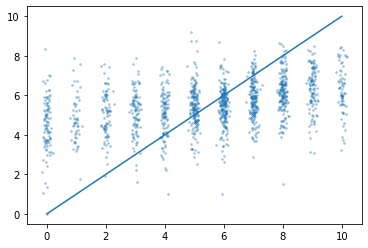

In [120]:
import matplotlib.pyplot as plt
plt.scatter(y_test + np.random.normal(0, 0.08, len(y_test)), X_test_KNN, alpha=0.3, s=3)
#plt.scatter(y_test+ np.random.normal(0, 0.08, len(y_test)), clf_stacking_KNN.predict(X_test_KNN), alpha=0.3, s=3)
plt.plot([0, 10], [0, 10])

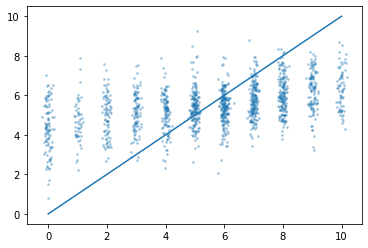

In [122]:
plt.scatter(y_test + np.random.normal(0, 0.08, len(y_test)), X_test_SVD, alpha=0.3, s=3)
#plt.scatter(y_test+ np.random.normal(0, 0.08, len(y_test)), clf_stacking_KNN.predict(X_test_KNN), alpha=0.3, s=3)
plt.plot([0, 10], [0, 10])

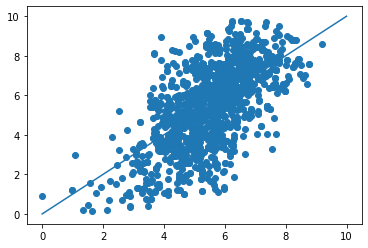

In [116]:
plt.scatter(X_test_KNN, clf_stacking_KNN.predict(X_test_KNN))
plt.plot([0, 10], [0, 10])

In [117]:
clf = RandomForestRegressor(**{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100}) #best param #TODO automate
clf.fit(np.concatenate((X_train, X_val), axis=0),
        np.concatenate((y_train, y_val), axis=0))
y_hat_test = clf.predict(X_test)

In [133]:
print(mean_squared_error(y_test, y_hat_test, squared=False))
print(mean_absolute_error(y_test, y_hat_test))

2.863800613822694
2.3198669141951433


In [ ]:
plt.scatter(y_test, y_hat_test)
plt.plot([0, 10], [0, 10])